<a href="https://colab.research.google.com/github/Charlotte-99/Y3Project/blob/main/Healpy_Map_Generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generating maps in Healpy

In [1]:
!pip install healpy

     |████████████████████████████████| 15.8MB 1.2MB/s 


In [2]:
import healpy as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import files
from matplotlib.colors import ListedColormap

## Importing Planck Maps
We can download the data from the official Planck map using https://irsa.ipac.caltech.edu/data/Planck/release_3/ancillary-data/ as our resource. This notebook section relies heavily on https://zonca.dev/2020/09/planck-spectra-healpy.html to format the data.

Here, after editing out the # at the beginning of the .txt file, we import the power spectrum. We also import a .txt file to generate a colourmap similar to what official Planck maps use.

(Alternatively, could use data files from CAMB).

In [3]:
uploaded = files.upload()

Saving planck_spectrum.txt to planck_spectrum.txt
Saving planck_map.txt to planck_map.txt


Using pandas, we can read the .txt file and then plot the power spectrum.

In [4]:
input_cl = pd.read_csv('planck_spectrum.txt', delim_whitespace=True, index_col=0)
input_cl.head()

cmap = ListedColormap(np.loadtxt('planck_map.txt')/255.)

We are mainly interested in the CMB TT spectrum (temperature angular power spectrum). 

Text(0.5, 0, '$\\ell$')

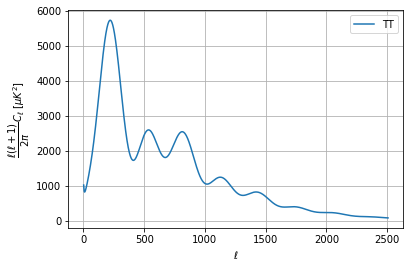

In [5]:
input_cl.plot(y='TT', grid=True)
plt.ylabel("$\dfrac{\ell(\ell+1)}{2\pi} C_\ell~[\mu K^2]$")
plt.xlabel("$\ell$")

We can transform our data to get our values for $C_\ell$ which we'll use in healpy. Note that we also take into account that this plot is in $\mu$K squared.

In [6]:
raw_cl = input_cl.divide(input_cl.index * (input_cl.index+1) / (2*np.pi),
                         axis='index') * 10**-12
raw_cl.head()

,TT,TE,EE,BB,PP
L,,,,,
2,1.064717e-09,2.741071e-12,3.234029e-14,1.904297e-18,5.250146e-20
3,5.046063e-10,1.538365e-12,2.078179e-14,1.904554e-18,3.193654e-20
4,2.867043e-10,8.666586e-13,1.083730e-14,1.904889e-18,2.207258e-20
5,1.831500e-10,4.925703e-13,4.836817e-15,1.905307e-18,1.639746e-20
6,1.269366e-10,2.836484e-13,1.937495e-15,1.905810e-18,1.276115e-20


We have no power spectrum values for $\ell = 0, 1$ so we can fill these in with zeroes.

In [7]:
lmax = raw_cl.index[-1]  # get maximum multipole

raw_cl = raw_cl.reindex(np.arange(0, lmax+1))  # reindex
raw_cl = raw_cl.fillna(0)  # fill missing vals
raw_cl.head()

,TT,TE,EE,BB,PP
L,,,,,
0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,1.064717e-09,2.741071e-12,3.234029e-14,1.904297e-18,5.250146e-20
3,5.046063e-10,1.538365e-12,2.078179e-14,1.904554e-18,3.193654e-20
4,2.867043e-10,8.666586e-13,1.083730e-14,1.904889e-18,2.207258e-20


## Generating CMB Maps
We can now move onto generating our fake CMB maps using this power spectrum. Here we will be using healpy's synfast function to generate a map. Alternatively, we could use healpy to generate the $a_{lm}$'s and then use this to generate a map.

Here, we use $n_\textrm{side}=2048$ to generate a map with the same resolution as the string maps.

In [9]:
map = hp.synfast(raw_cl.TT, nside=2048, lmax=lmax, new=True)

/usr/local/lib/python3.7/dist-packages/healpy/sphtfunc.py:824: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  sigma * 60 * 180 / np.pi, sigma
/usr/local/lib/python3.7/dist-packages/healpy/sphtfunc.py:829: UserWarning: -> fwhm is 0.000000 arcmin
  sigma * 60 * 180 / np.pi * (2.0 * np.sqrt(2.0 * np.log(2.0)))


We can now plot the map using Mollview projection. To compare with the Planck map, we can specify the range.

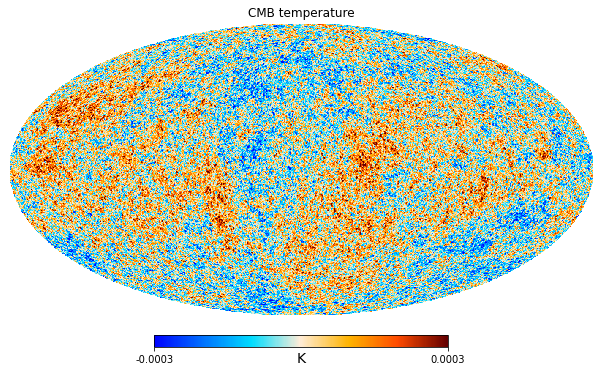

In [10]:
hp.mollview(map, cmap=cmap, unit='K', title='CMB temperature',
            min=-300e-6, max=300e-6)

We can plot the spectrum of our map using healpy's anafast routine.

In [11]:
map_cl = hp.anafast(map, lmax=lmax, use_pixel_weights=True) * 1e12
ell = np.arange(map_cl.size)
map_cl *= ell * (ell+1) / (2*np.pi)

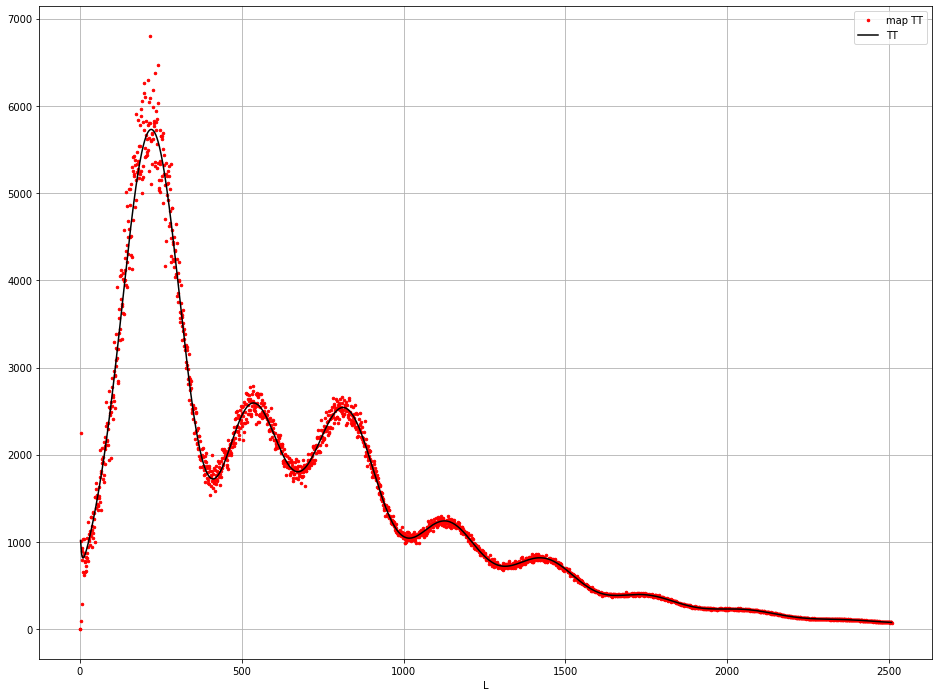

In [12]:
plt.figure(figsize=(16, 12))
plt.plot(map_cl, label='map TT', marker='.', markersize=5, linestyle='None',
         color='red')
input_cl.TT.plot(grid=True, color='black')
plt.legend()

### Partial plotting
We can plot small sections of our CMB map using gnomonic view. To do this, we will use the healpy's gnomview routine.

First we will experiment with projecting our map using default arguments.

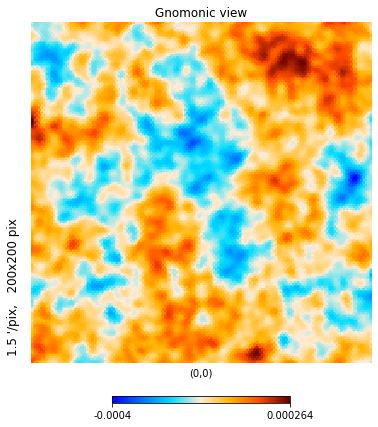

In [13]:
hp.visufunc.gnomview(map, cmap=cmap)

Note that this does not plot the whole map, but only a small region. The resolution is (by default) 1.5 arcmin and the image dimensions are 200x200. So this is a 5 degree squared cutout taken from latitude=0, longitude=0. 

We can write a function to extract specific regions of specific sizes. For example, if we want a 10 degree squared patch to correspond to an image size 200 x 200, we need a resolution of 3 arcmin.

Recall: $1' = \frac{1}{60}^{\circ}$

Then for an image with a side of $n$ degrees and a side of $N$ pixels:

$\textrm{resolution} = 60\frac{n}{N}' $


In [14]:
def extract_map(map, rot, deg_side, pixel_side, cmap='jet'):
  '''
  rot must be a tuple (lon, lat, psi) where lon, lat specify where the
  centre of the extracted map will be and psi specifies a rotation.
  All of these are in units of degrees.
  '''
  reso = 60*deg_side/pixel_side
  mini_map = hp.visufunc.gnomview(map, rot=rot, xsize=pixel_side,
                                  reso=reso, return_projected_map=True,
                                  no_plot=False, cmap=cmap)
  return reso, mini_map

We can then use this to extract, for example, a 200x200 sized image for a 10 degree squared patch centred on lon=30, lat = -30.

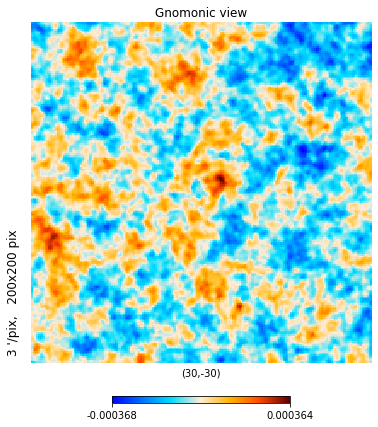

In [15]:
reso, mini_map = extract_map(map, (30, -30, 0), 10, 200, cmap=cmap)

The array will be stored in the mini_map variable.

In [17]:
print(mini_map.shape)
print(mini_map)

(200, 200)
[[-1.26089642e-04 -1.04198633e-04 -1.01996232e-04 ...  2.77182992e-05
  -4.30516528e-05 -4.89523026e-05]
 [-5.66887578e-05 -3.96799863e-05 -1.25810777e-05 ...  1.35921833e-05
  -3.41075476e-05 -3.25580118e-05]
 [-3.40924880e-05 -2.01229790e-05 -1.44997723e-05 ... -1.03932654e-05
  -5.15836059e-05 -2.73437221e-05]
 ...
 [-2.30664990e-04 -2.25272130e-04 -2.24720877e-04 ... -5.65190421e-05
  -8.49165185e-05 -1.13394414e-04]
 [-2.33336362e-04 -2.30894988e-04 -2.28247210e-04 ... -6.28730911e-05
  -7.63688222e-05 -9.51911892e-05]
 [-1.98524423e-04 -2.20959366e-04 -2.20127879e-04 ... -7.24432503e-05
  -6.53220319e-05 -6.90045985e-05]]


## Saving maps
In this section, we will generate maps from healpy and save these to .fits files. We can then use these files later to extract smaller sized maps and combine these with the string cosmic maps.

In [ ]:
num_maps = 3  # number of maps to generate

for n in range(num_maps):
  name = f'cmb_map{n}.fits'
  map = hp.synfast(raw_cl.TT, nside=2048, lmax=lmax)
  hp.fitsfunc.write_map(name, map)